# Tree Data Generation

This notebook is responsible for generating synthetic data used in benchmarking LLMs on hierarchical reasoning tasks.

### What it does:

- Generates random tree structures with configurable size and branching density.
- Assigns unique names to nodes using a predefined list from `data/random_names.txt`.
- Produces natural language descriptions of each tree, capturing the parent-child relationships in text form.
- Generates algorithmically answerable queries (e.g., tree depth, lowest common ancestor) along with correct answers.
- Saves structured datasets for use in benchmark evaluations.

### Parameters:

- `tree_size`: number of nodes in the tree.
- `density`: maximum number of children per node.
- Random seed: ensures reproducibility of the generated data.

This notebook is the first step in the pipeline and must be run before evaluating model performance in `comparison.ipynb`.


In [37]:
import pathlib
from typing import Dict, Tuple, List
from collections import defaultdict
import csv
import random
import numpy
from llm_comparison.generators import generate_tree, tree_to_text, lca
from llm_comparison.custom_types import QAExample
from llm_comparison.visualizers import visualize_tree_grid

In [2]:
numpy.random.seed(42)
random.seed(42)

In [3]:
names = []
with open("../data/random_names.txt") as names_file:
    for name in names_file:
        names.append(name.strip())

In [15]:
dataset = defaultdict(list)
sample_nums = 3
tree_sizes = numpy.concatenate(
    [numpy.arange(3, 10, 2), numpy.arange(10, 100, 10)]
)
densities = list(range(1, 10))
for size in tree_sizes:
    for density in densities:
        for _ in range(sample_nums):
            tree = generate_tree(size=size, density=density, names=names)
            text_description = tree_to_text(tree)
            [q, p] = random.choices(names[0: size - 1], k=2)
            query = f"Who is lowest (youngest) common ancestor for {q} and {p}? Only name, one name, nothing else."
            answer = lca(tree=tree, p=p, q=q)
            dataset[(size, density)].append(
                QAExample(
                    tree,
                    text_description,
                    query,
                    answer
                )
            )

Example of how one tree looks like and how it's represented

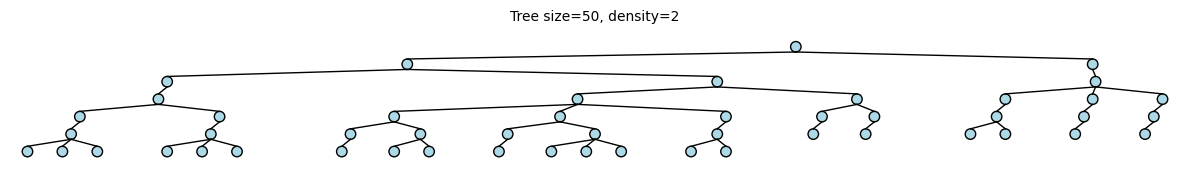

In [22]:
k = (50, 2)
param = f"size={k[0]}, density={k[1]}"
visualize_tree_grid([[dataset[k][0].tree]], [[param]])

In [25]:
print(dataset[k][0].text + "\n" + dataset[k][0].query)

Belinda is parent for Becky and Barry. Becky is parent for Barbara and Bailey. Barry is parent for Austin. Barbara is parent for Audrey. Bailey is parent for Ashley and Arthur. Austin is parent for Ariel and Ariana and April. Audrey is parent for Antonio and Anthony. Ashley is parent for Anna and Ann and Anita. Arthur is parent for Angie and Angelica. Ariel is parent for Angela. Ariana is parent for Angel. April is parent for Andrew. Antonio is parent for Andres. Anthony is parent for Andrea. Anna is parent for Andre and Amy. Ann is parent for Amber and Amanda. Anita is parent for Alyssa. Angie is parent for Allison. Angelica is parent for Allen. Angela is parent for Alison and Alicia. Angel is parent for Alice. Andrew is parent for Alexis. Andres is parent for Alexandria and Alexandra and Alexander. Andrea is parent for Alexa and Alex and Alejandro. Andre is parent for Alejandra. Amy is parent for Alec and Albert. Amber is parent for Alan. Amanda is parent for Adriana and Adrian and A

In [26]:
dataset[k][0].answer

'Amanda'

Overall trees looks like that

In [29]:
sizes = sorted(set(size for (size, _) in dataset if size < 30))
densities = sorted(set(density for (_, density) in dataset))

trees_2d = []
parameters = []

for size in sizes:
    row_trees = []
    row_params = []
    for density in densities:
        examples = dataset.get((size, density), [])
        if examples:
            row_trees.append(examples[0].tree)
            row_params.append(f"{size},{density}")
    trees_2d.append(row_trees)
    parameters.append(row_params)

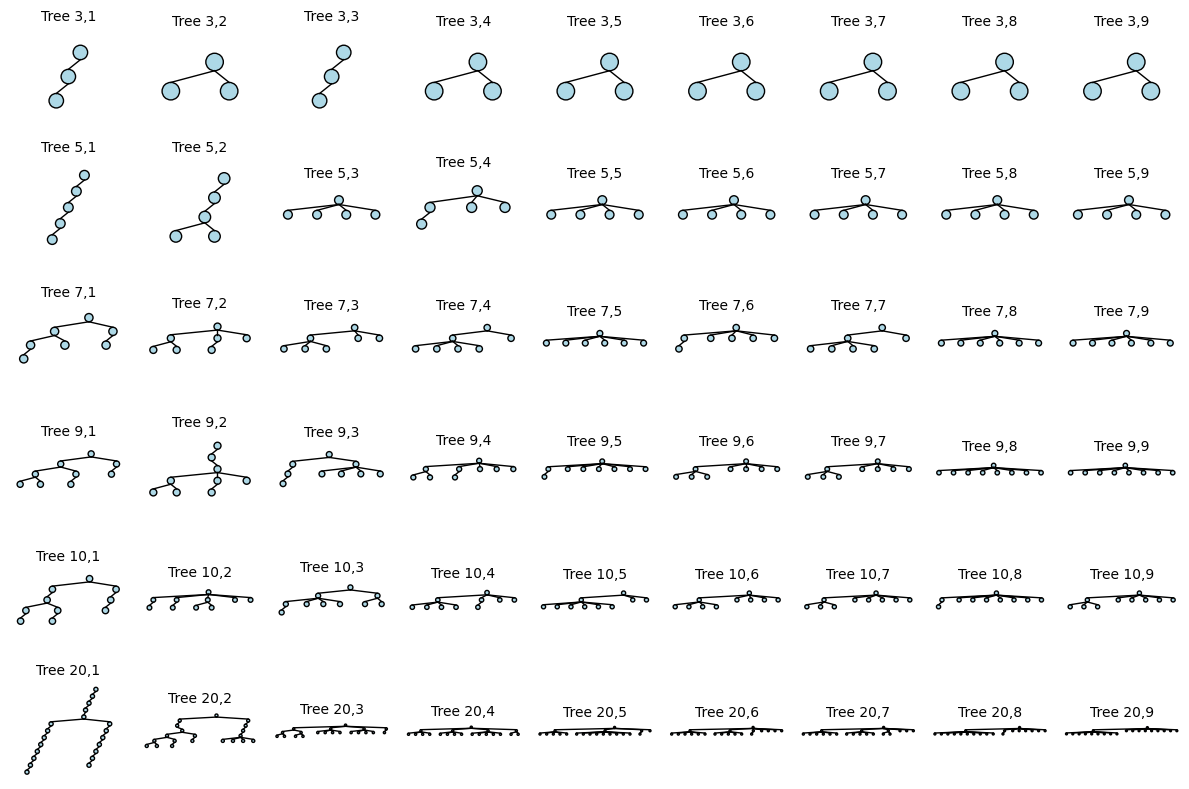

In [30]:
visualize_tree_grid(trees_2d, parameters)

Saving the dataset of queries and answers

In [38]:
def save_qa_dataset_to_csv(
    dataset: Dict[Tuple[int, float], List[QAExample]], 
    filename: pathlib.Path
) -> None:
    with open(filename, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["size", "density", "text", "query", "answer"])
        for (size, density), examples in dataset.items():
            for ex in examples:
                writer.writerow([size, density, ex.text, ex.query, ex.answer])

In [39]:
save_qa_dataset_to_csv(dataset, pathlib.Path("../data/qa_dataset.csv"))